In [1]:
%reload_ext autoreload
%autoreload 2
#%reload_ext notexbook'
#%texify

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/notebooks')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5

In [3]:
param_file = '../cellbgnet/utils/reference_files/reference.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)

In [4]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']

In [5]:
psf_size = 41
xextent = [-0.5, 127.5]
yextent = [-0.5, 127.5]
zextent = [-400, 400]
scale = torch.tensor([(xextent[1] - xextent[0]),
                      (yextent[1] - yextent[0]),
                      (zextent[1] - zextent[0])])
shift = torch.tensor([xextent[0], yextent[0], zextent[0]])

In [6]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
roi_size=None, roi_auto_center=None, normalize=False)

INITIATING CPU IMPLEMENTATION


In [7]:
xyz = (torch.tensor([60, 60, -500])).view(-1, 3)
photon_scale = 3000
photons = torch.ones((xyz.shape[0]))*photon_scale

In [8]:
im = psf.forward(xyz, photons);


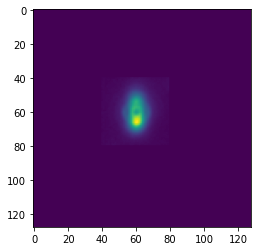

In [9]:
plt.imshow(im[0, :,:])

In [10]:
from time import sleep
x_list = list(range(-500,500))
def test_psf(normalize=True, ix = 0):
    psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
    xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
    roi_size=None, roi_auto_center=None, normalize=normalize)
    photon_sum = []
    crlbs = []
    d_sums = []
    for z in range(-500, 500):
        xyz = (torch.tensor([60, 60, z])).view(-1, 3)
        photon_scale = 3000
        photons = torch.ones((xyz.shape[0]))*photon_scale
        im = psf.forward(xyz, photons);
        bg = torch.random(im.shape[1], im.shape[2])

        crlb = psf.crlb(xyz, photons, bg);
        crlbs.append(crlb[0][0][ix].item())
        photon_sum.append(im.sum())
        d = psf.derivative(xyz, photons, bg);
        d_sums.append(d[0][0][ix].sum().item())

    return crlbs, photon_sum, d_sums

In [11]:
ix = 2

crlbs_norm, phot_norm, d_norm = test_psf(True,ix)


INITIATING CPU IMPLEMENTATION
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.296159. Z: 47.879997. sq: 1.680028 
Deriv sums: x: -0.342825, y: -6.029962 , z: -242.862061 
The factor is: 1.296159. Z: 47.879997. sq: 1.680028 
Deriv sums: x: -0.342825, y: -6.029962 , z: -242.862061 
The factor is: 1.290786. Z: 47.840000. sq: 1.666128 
Deriv sums: x: -0.343351, y: -6.08013

[8020.90625,
 7726.3623046875,
 7453.9921875,
 7202.06005859375,
 6969.20947265625,
 6753.89990234375,
 6554.95263671875,
 6371.0634765625,
 6201.2099609375,
 6044.30908203125,
 5899.36572265625,
 5765.54638671875,
 5642.0,
 5527.92919921875,
 5422.6923828125,
 5325.56298828125,
 5235.99072265625,
 5153.41845703125,
 5077.30078125,
 5007.1884765625,
 4942.63037109375,
 4883.20458984375,
 4828.57177734375,
 4778.345703125,
 4732.234375,
 4689.94580078125,
 4651.20751953125,
 4615.80712890625,
 4583.4970703125,
 4554.06396484375,
 4527.28759765625,
 4502.978515625,
 4480.95458984375,
 4461.0498046875,
 4443.1171875,
 4427.00439453125,
 4412.5859375,
 4399.74267578125,
 4388.34765625,
 4378.3076171875,
 4369.51611328125,
 4361.8876953125,
 4355.3349609375,
 4349.7822265625,
 4345.15576171875,
 4341.3935546875,
 4338.42529296875,
 4336.1982421875,
 4334.65625,
 4333.7509765625,
 4333.43212890625,
 4333.6640625,
 4334.39404296875,
 4335.58837890625,
 4337.19140625,
 4339.169921875,
 4341.47

(0.0, 3100.0)

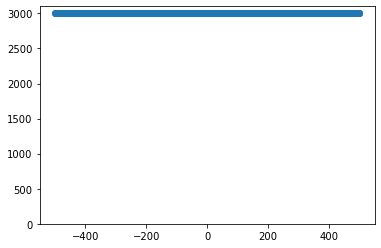

In [12]:

plt.plot(list(range(-500, 500)), phot_norm, 'o')
plt.ylim([0, 3100])

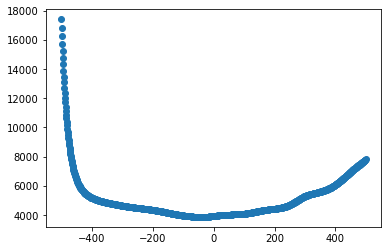

In [29]:
plt.plot(list(range(-500, 500)), crlbs_norm, 'o')

In [14]:
crlbs, phot, d_sum = test_psf(False, ix)

INITIATING CPU IMPLEMENTATION


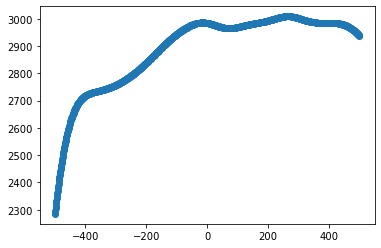

In [15]:
plt.plot(list(range(-500, 500)), phot, 'o')


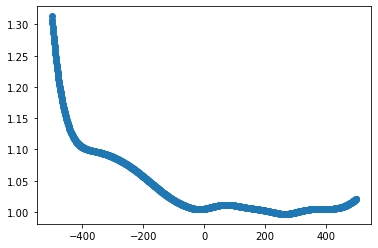

In [16]:
plt.plot(list(range(-500, 500)), np.array(phot_norm)/np.array(phot), 'o')


INITIATING CPU IMPLEMENTATION

Deriv sums: x: 6.790749, y: 0.142507 , z: 22.974758 
The factor is: 1.015422. Z: 8.639999. sq: 1.031082 
Deriv sums: x: 6.833322, y: 0.153991 , z: 23.380407 
The factor is: 1.015422. Z: 8.639999. sq: 1.031082 
Deriv sums: x: 6.833322, y: 0.153991 , z: 23.380407 
The factor is: 1.015746. Z: 8.600000. sq: 1.031741 
Deriv sums: x: 6.875944, y: 0.165429 , z: 23.789543 
The factor is: 1.015746. Z: 8.600000. sq: 1.031741 
Deriv sums: x: 6.875944, y: 0.165429 , z: 23.789543 
The factor is: 1.016078. Z: 8.559999. sq: 1.032414 
Deriv sums: x: 6.918340, y: 0.176805 , z: 24.202129 
The factor is: 1.016078. Z: 8.559999. sq: 1.032414 
Deriv sums: x: 6.918340, y: 0.176805 , z: 24.202129 
The factor is: 1.016412. Z: 8.520000. sq: 1.033094 
Deriv sums: x: 6.960693, y: 0.188130 , z: 24.618158 
The factor is: 1.016412. Z: 8.520000. sq: 1.033094 
Deriv sums: x: 6.960693, y: 0.188130 , z: 24.618158 
The factor is: 1.016756. Z: 8.480000. sq: 1.033792 
Deriv sums: x: 7.002610,

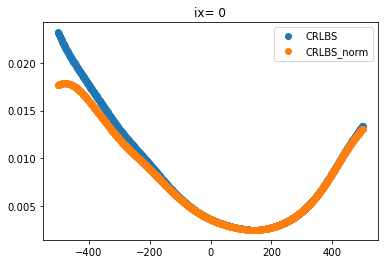

INITIATING CPU IMPLEMENTATION
.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The factor is: 1.019715. Z: 8.160000. sq: 1.039819 
Deriv sums: x: 7.330388, y: 0.285600 , z: 28.518101 
The factor is: 1.019715. Z: 8.160000. sq: 1.039819 
Deriv sums: x: 7.330388, y: 0.285600 , z: 28.518101 
The factor is: 1.020114. Z: 8.120001. sq: 1.040632 
Deriv sums: x: 7.369988, y: 0.295762 , z: 28.968771 
The factor is: 1.020114. Z: 8.120001. sq: 1.040632 
Deriv sums: x: 7.369988, y: 0.295762 , z: 28.968771 
The factor is: 1.020519. Z: 8.080000. sq: 1.041458 
Deriv sums: x: 7.408954, y: 0.305753 , z: 29.422819 
The factor is: 1.020519. Z: 8.080000. sq:

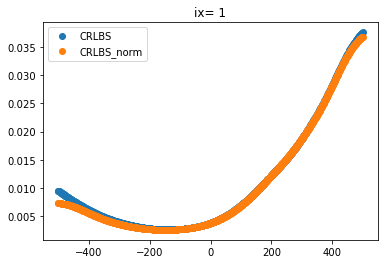

INITIATING CPU IMPLEMENTATION
805 , z: 24.202129 
The factor is: 1.016412. Z: 8.520000. sq: 1.033094 
Deriv sums: x: 6.960693, y: 0.188130 , z: 24.618158 
The factor is: 1.016412. Z: 8.520000. sq: 1.033094 
Deriv sums: x: 6.960693, y: 0.188130 , z: 24.618158 
The factor is: 1.016756. Z: 8.480000. sq: 1.033792 
Deriv sums: x: 7.002610, y: 0.199373 , z: 25.037666 
The factor is: 1.016756. Z: 8.480000. sq: 1.033792 
Deriv sums: x: 7.002610, y: 0.199373 , z: 25.037666 
The factor is: 1.017104. Z: 8.440001. sq: 1.034500 
Deriv sums: x: 7.044642, y: 0.210539 , z: 25.460608 
The factor is: 1.017104. Z: 8.440001. sq: 1.034500 
Deriv sums: x: 7.044642, y: 0.210539 , z: 25.460608 
The factor is: 1.017458. Z: 8.400000. sq: 1.035221 
Deriv sums: x: 7.086333, y: 0.221616 , z: 25.887028 
The factor is: 1.017458. Z: 8.400000. sq: 1.035221 
Deriv sums: x: 7.086333, y: 0.221616 , z: 25.887028 
The factor is: 1.017818. Z: 8.360001. sq: 1.035953 
Deriv sums: x: 7.127769, y: 0.232586 , z: 26.316797 
The f

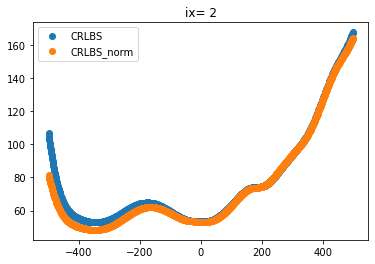

INITIATING CPU IMPLEMENTATION
 
Deriv sums: x: 7.447833, y: 0.315576 , z: 29.880350 
The factor is: 1.020931. Z: 8.040001. sq: 1.042299 
Deriv sums: x: 7.447833, y: 0.315576 , z: 29.880350 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.313092. Z: 48.000000. sq: 1.724210 
Deriv sums: x: -0.337947, y: -5.874294 , z: -254.566238 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.307308. Z: 47.959999. sq: 1.709054 
Deriv sums: x: -0.340006, y: -5.927022 , z: -250.636841 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.301666. Z: 47.919998. sq: 1.694335 
Deriv sums: x: -0.341731, y: -5.978931 , z: -246.735596 
The factor is: 1.296159. Z: 47.879997. sq: 1.680028 
Deriv sums: x: -0.342825, y: -6.029962 , z: -242.862061 
The factor is: 1.296159. Z: 47.879997. s

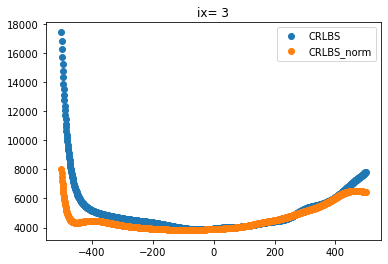

INITIATING CPU IMPLEMENTATION
 1.018185. Z: 8.320000. sq: 1.036700 
Deriv sums: x: 7.168783, y: 0.243448 , z: 26.750195 
The factor is: 1.018185. Z: 8.320000. sq: 1.036700 
Deriv sums: x: 7.168783, y: 0.243448 , z: 26.750195 
The factor is: 1.018558. Z: 8.280001. sq: 1.037460 
Deriv sums: x: 7.209823, y: 0.254193 , z: 27.186964 
The factor is: 1.018558. Z: 8.280001. sq: 1.037460 
Deriv sums: x: 7.209823, y: 0.254193 , z: 27.186964 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.018937. Z: 8.240000. sq: 1.038233 
Deriv sums: x: 7.250308, y: 0.264804 , z: 27.627228 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The factor is: 1.019323. Z: 8.200001. sq: 1.039019 
Deriv sums: x: 7.290502, y: 0.275270 , z: 28.070963 
The factor is: 1.019715. Z: 8.160000. sq: 1.039819 
Deriv sums: x: 7.330388, y: 0.285600 , z: 28.518101 
The factor is: 1.019715. Z: 8.160000. s

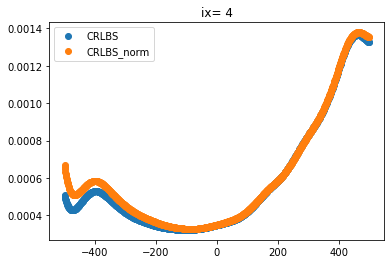

In [37]:
for ix in range(0, 5):

    crlbs_norm, phot_norm, d_norm = test_psf(True,ix)
    crlbs, phot, d = test_psf(False,ix)


    plt.plot(np.array(list(range(-500, 500))), crlbs, 'o')
    plt.plot(np.array(list(range(-500, 500))), crlbs_norm, 'o')
    plt.legend(['CRLBS', 'CRLBS_norm'])
    plt.title(f'ix= {ix}')
    plt.show()

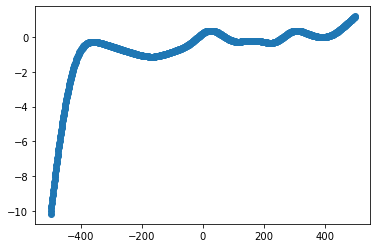

In [18]:
plt.plot(np.array(list(range(-500, 500))), d_sum, 'o')
#plt.plot(np.array(list(range(-500, 500))), d_norm, 'o')
# plt.legend(['d_sums', 'd_sum_norm'])

In [19]:
psf_norm = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
roi_size=None, roi_auto_center=None, normalize=True)

psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 127.5], yextent=[-0.5, 127.5], img_shape=[128, 128], device='cpu', 
roi_size=None, roi_auto_center=None, normalize=False)

INITIATING CPU IMPLEMENTATION
INITIATING CPU IMPLEMENTATION


In [20]:
xyz = (torch.tensor([60, 60, -500])).view(-1, 3)
photon_scale = 3000
photons = torch.ones((xyz.shape[0]))*photon_scale
bg = torch.zeros(im.shape[1], im.shape[2])


d_norm = psf_norm.derivative(xyz, photons, bg)[0][0,0,:,:]
d = psf.derivative(xyz, photons, bg)[0][0,0,:,:]

In [36]:
crlb = psf_norm.crlb(xyz, photons, bg)
crlb[0]

tensor([[1.3157e-02, 3.6846e-02, 1.6489e+02, 6.4397e+03, 1.3513e-03]])

In [ ]:
sqd = ((d_norm - d)**2)
print(sqd.sum())

tensor(557.3178)


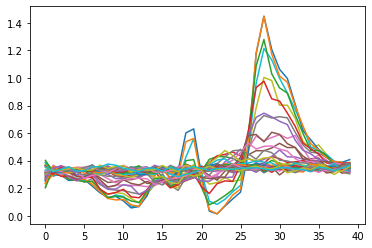

In [ ]:
plt.plot(sqd);

In [ ]:
sqdiffs = []
diffs = []

crlb_diffs = []

for z in range(-500, 500):
    xyz = (torch.tensor([60, 60, z])).view(-1, 3)
    photon_scale = 3000
    photons = torch.ones((xyz.shape[0]))*photon_scale
    im = psf.forward(xyz, photons);
    bg = torch.zeros(im.shape[1], im.shape[2])
    d_norm = psf_norm.derivative(xyz, photons, bg)[0][0,0,:,:]
    d = psf.derivative(xyz, photons, bg)[0][0,0,:,:]

    crlb_norm = psf_norm.crlb(xyz, photons, bg)[0][0,0]
    crlb = psf.crlb(xyz, photons, bg)[0][0,0]


    sqd = ((d_norm - d)**2)

    diff = (d_norm - d)

    sqdiffs.append(sqd.sum())
    diffs.append(diff.sum())

    crlb_diffs.append(crlb_norm - crlb)

U /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU /nON CPU

In [ ]:
plt.plot(list(range(-500, 500)), np.array(diffs)*1, 'o')
plt.show()

In [ ]:
crlbs_norm

[5.799393653869629,
 -13.263617515563965,
 -64.068359375,
 25.965478897094727,
 52.38219451904297,
 -22.063671112060547,
 -24.9357967376709,
 -41.32850646972656,
 29.975767135620117,
 -9.189653396606445,
 8.339516639709473,
 20.96863555908203,
 97.47074890136719,
 -10.282788276672363,
 19.19579315185547,
 30.079662322998047,
 18.816688537597656,
 62.057106018066406,
 13.187690734863281,
 -56.94609069824219,
 97.42704010009766,
 27.400774002075195,
 519.1993408203125,
 46.295345306396484,
 40.78878402709961,
 49.89659118652344,
 21.763601303100586,
 -525.5457153320312,
 -928.3713989257812,
 -61.176109313964844,
 41.54264831542969,
 81.52052307128906,
 -440.2982177734375,
 90.7850570678711,
 55.67714309692383,
 71.60385131835938,
 352.43304443359375,
 107.79940032958984,
 35.00244903564453,
 35.3426513671875,
 32.50963592529297,
 83.64551544189453,
 295.7366027832031,
 23.924301147460938,
 42.414337158203125,
 26.535419464111328,
 43.00767517089844,
 61.60273742675781,
 130.9327239990234

In [22]:
d = psf.derivative(xyz, photons, bg);


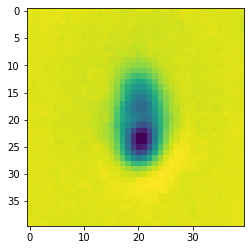

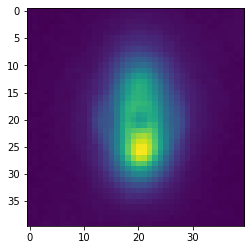

In [23]:
plt.imshow(d[0][0, 2])
plt.show()
plt.imshow(psf.forward(xyz, photons)[0, 40:80, 40:80])
plt.show()

In [24]:
xyz[0,2] = 500

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 39.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 33.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8., 32.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  6., 31.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  5., 30.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  4.,  2.,  4., 29.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  2.,  3.,  3., 29.],
        [ 0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  4., 28.],
        [ 0.,  0.,  0.,  1.,  2.,  2.,  

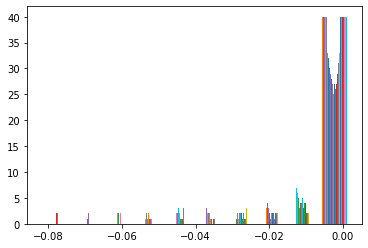